In [1]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [216]:
# Load Data

fpath = "../../Data/"
fpathchar = "20180423/"

fname_lesson = fpath + fpathchar + "complete_lh_sample.csv"
fname_subspt = fpath + fpathchar + "subscription_dates_list.csv"

df_lesson = pd.read_csv(fname_lesson, delimiter=',')
df_subspt = pd.read_csv(fname_subspt, delimiter=',')

## Pre-process data

# Renew DataFrame indices
df_lesson.set_index('lesson_history_id', inplace=True)

time_format = "%H:%M:%S"
date_format = "%Y-%m-%d"

# Covert duration string to numerics (in seconds)
df_lesson.timeTaken = pd.to_datetime(df_lesson.timeTaken, format=time_format)
root_datetime = pd.to_datetime("00:00:00", format=time_format)
df_lesson.timeTaken = df_lesson.timeTaken - root_datetime
df_lesson.timeTaken = df_lesson.timeTaken.dt.seconds

# Convert datetime string to object
df_lesson.marked = pd.to_datetime(df_lesson.marked, format=date_format+" "+time_format)

In [217]:
df_lesson.head()

,pupilId,topicId,age,exerciseId,marked,stackDepth,outcome,timeTaken,leson_type
lesson_history_id,,,,,,,,,
75863081,926676,AA,675,100,2015-09-10 16:12:20,1,p,115,tutor_ex
75863178,926676,AA,675,100,2015-09-10 16:14:39,1,p,94,tutor_pb
75863310,926676,QA,500,100,2015-09-10 16:17:30,1,p,127,tutor_ex
75863357,926676,QA,500,100,2015-09-10 16:18:30,1,p,39,tutor_pb
75863635,926676,RA,600,100,2015-09-10 16:23:26,1,p,126,tutor_ex


In [218]:
df_subspt.subscription_start_date = pd.to_datetime(df_subspt.subscription_start_date, format=date_format)
df_subspt.subscription_end_date = pd.to_datetime(df_subspt.subscription_end_date, format=date_format)

df_subspt['subscription_length'] = (df_subspt.subscription_end_date-df_subspt.subscription_start_date).dt.days

df_subspt.head()

,pupilId,subscription_type,subscription_start_date,subscription_end_date,codeCountry,subscription_length
0,13358,Annual,2012-11-10,2013-11-10,GBR,365
1,13359,Annual,2012-11-10,2013-11-10,GBR,365
2,6655,Annual,2013-05-13,2014-05-13,GBR,365
3,20940,Monthly,2013-08-20,2013-09-20,GBR,31
4,20940,Monthly,2013-09-20,2013-10-20,GBR,30


In [219]:
topic_list = df_lesson.topicId.unique()
pupil_list = df_lesson.pupilId.unique()
pupil = pupil_list[0]

p_lesson = df_lesson[df_lesson.pupilId==pupil]

# Distribution of subscription length per pupil

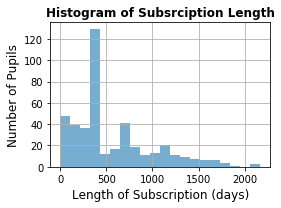

In [270]:
# Distribution of subscription length per pupil
sub_length = np.array(df_subspt.groupby('pupilId')['subscription_length'].sum())

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.hist(sub_length, bins=20, alpha=0.6)
ax.set_xlabel("Length of Subscription (days)")
ax.set_ylabel("Number of Pupils")
ax.set_title("Histogram of Subsrciption Length")
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Active subscriptions over time
x - Date
<br> y - Number of active subscriptions
# Average remaining subscription length
x - Date
<br> y - Average subscription time length left per student

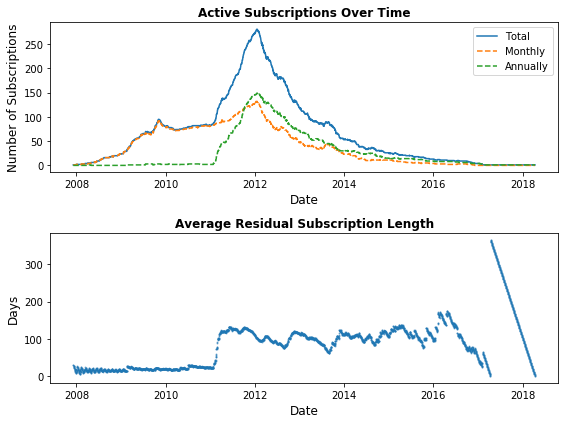

In [325]:
last_date = df_subspt.subscription_end_date.max()
first_date = df_subspt.subscription_start_date.min()

dates = list(pd.date_range(start=first_date, end=last_date, freq='D'))
num_subspt = np.zeros(len(dates)-1)
num_subspt_monthly = np.zeros(len(dates)-1)
num_subspt_annually = np.zeros(len(dates)-1)
res_subspt_length = np.zeros(len(dates)-1)
dates = dates[0:len(dates)-1]

temp = df_subspt.groupby(['subscription_start_date', 'subscription_length']).count()
for row in temp.itertuples(index=True):
    start_date, length = row.Index
    i_start = dates.index(start_date)
    # Number of subscriptions
    if length > 31:
        num_subspt_annually[i_start : i_start+length] = \
        num_subspt_annually[i_start : i_start+length] + 1*row.subscription_type
    else:
        num_subspt_monthly[i_start : i_start+length] = \
        num_subspt_monthly[i_start : i_start+length] + 1*row.subscription_type
    # Residual subscrption length
    res_subspt_length[i_start : i_start+length] = \
    res_subspt_length[i_start : i_start+length] + np.arange(length,0,-1)*row.subscription_type
num_subspt = num_subspt_monthly + num_subspt_annually
res_subspt_length = res_subspt_length / num_subspt
df_subspt_overtime = pd.DataFrame({'num_subscriptions': num_subspt,
                                  'num_subscriptions_monthly': num_subspt_monthly,
                                  'num_subscriptions_annually': num_subspt_annually,
                                  'res_subscriptions_length': res_subspt_length}, index=dates)

# We can also have the data in different frequencies, like monthly
# df_subspt_overtime_monthly = df_subspt_overtime.resample('M').sum()

# Active subscriptions over time
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(211)
ax.plot(df_subspt_overtime.index, df_subspt_overtime.num_subscriptions, label='Total')
ax.plot(df_subspt_overtime.index, df_subspt_overtime.num_subscriptions_monthly, '--', label='Monthly')
ax.plot(df_subspt_overtime.index, df_subspt_overtime.num_subscriptions_annually, '--', label='Annually')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Subscriptions')
ax.set_title('Active Subscriptions Over Time')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')
ax.legend()

# Average remaining subscription length
ax = fig.add_subplot(212)
ax.plot(df_subspt_overtime.index, df_subspt_overtime.res_subscriptions_length, 'o', markersize=1, alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Days')
ax.set_title('Average Residual Subscription Length')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_fontsize(12)
ax.title.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [ ]:
# Cancellation and renewal counts over time
# Monthly/Annually/Total renewal
# M --> A renewal
# A --> M renewal